In [1]:
import math
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import layers, models, losses, optimizers
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings
print(tf.config.list_physical_devices('GPU'))

2023-05-07 07:34:36.417625: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# import dataset
datapath = "../wildfire_dataset.nc"
wildfire_dataset = xr.open_dataset(datapath, engine="netcdf4")
# print(wildfire_dataset)
feature_list = wildfire_dataset.data_vars
feature_nums = len(feature_list)

# maybe predict more than one thing later, but for not only try to predict burned areas
remove_label = ["burned_areas", "ignition_points", "number_of_fires", "POP_DENS_2009", "POP_DENS_2010", "POP_DENS_2011", "POP_DENS_2012", "POP_DENS_2013", "POP_DENS_2014", "POP_DENS_2015", "POP_DENS_2016", "POP_DENS_2017", "POP_DENS_2018", "POP_DENS_2019", "POP_DENS_2020", "POP_DENS_2021", "ROAD_DISTANCE"]
X_label = [label for label in feature_list if label not in remove_label]
y_label = "burned_areas"
Xy_label = X_label
Xy_label.append(y_label)

/usr/local/lib/python3.8/dist-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [3]:
start_timestep = 100
num_samples = 10
timesteps_per_sample = 2
width_limit = 100
height_limit = 100
timestep_samples = num_samples*timesteps_per_sample
train_size = 0.7

In [4]:
# DATA PROCESSING
# 1) Train Test Split
# 2) Convert train, test sets into np array
# 3) For the train set, weight/multiply the fire dataset and combine it with the non fire dataset (Class weighting)
# 4) Leave the test set as is (No need for class weighting because only used for testing)

# partial dataset (limit x and y coords)
# train_dataset = wildfire_dataset.isel(time=slice(None,math.floor(timestep_samples*train_size)), x=slice(None,width_limit), y=slice(None,height_limit))
# train_dataset = train_dataset[Xy_label]
# test_dataset = wildfire_dataset.isel(time=slice(math.floor(timestep_samples*train_size),timestep_samples), x=slice(None,width_limit), y=slice(None,height_limit))
# test_dataset = test_dataset[Xy_label]

In [5]:
# full dataset
train_dataset = wildfire_dataset.isel(time=slice(start_timestep, start_timestep+timestep_samples))
train_dataset = train_dataset[Xy_label]

In [6]:
# axis_2_size is the timesteps for the dataset
def dataset_to_np(dataset, axis_2_size):
    # # Create the X into a numpy matrix of shape (time, x, y)
    ds_np = dataset[list(dataset.data_vars)[0]].to_numpy()
    ds_np = np.transpose(ds_np, (0,2,1))
    ds_np = np.expand_dims(ds_np, 3)

    for index, feature in enumerate(list(dataset.data_vars)):
        print(feature)
        if(index > 0):
            # Since wf_dataset_X_np is already initiaklized with the first element, skip
            new_np_arr = dataset[feature].to_numpy()
            print("new_np_arr.shape: ", new_np_arr.shape)
            # print("new_np_arr shape: ",new_np_arr.shape)
            if(len(new_np_arr.shape) == 2):
                # If a feature doesn't contain a time dimension (n), we extend the 2d matrix to 3d with copy of matrix n times
                # Might be able to use numpy broadcast instead
                new_np_arr = np.repeat(new_np_arr[:, :, np.newaxis], axis_2_size, axis=2)
                # Transpose feature to "time", "x", "y" format
                new_np_arr = np.transpose(new_np_arr)
            else:
                # Transpose feature to "time", "x", "y" format
                new_np_arr = np.transpose(new_np_arr, (0,2,1))
            if (np.isnan(new_np_arr).all()):
                # Precaution to alert if a feature has all NaN values
                warnings.warn(str(feature) + " feature's values are all NaNs")
            if (np.isnan(new_np_arr).any()):
                # Precaution to alert if a feature has all NaN values
                warnings.warn(str(feature) + " feature's values has NaNs")
            # print(new_np_arr.shape)
            ds_np = np.concatenate((ds_np, np.expand_dims(new_np_arr, axis=3)), axis=3)
        print(ds_np.shape)
    return ds_np

In [7]:
# Convert train and test to numpy arrays (time, x, y)
train_np = dataset_to_np(train_dataset, timestep_samples)

ndvi
(20, 1253, 983, 1)
evi
new_np_arr.shape:  (20, 983, 1253)
(20, 1253, 983, 2)
et


/tmp/ipykernel_410/1721584199.py:29: UserWarning: evi feature's values has NaNs
  warnings.warn(str(feature) + " feature's values has NaNs")


new_np_arr.shape:  (20, 983, 1253)
(20, 1253, 983, 3)
lst_day
new_np_arr.shape:  (20, 983, 1253)


/tmp/ipykernel_410/1721584199.py:29: UserWarning: lst_day feature's values has NaNs
  warnings.warn(str(feature) + " feature's values has NaNs")


(20, 1253, 983, 4)
lst_night
new_np_arr.shape:  (20, 983, 1253)


/tmp/ipykernel_410/1721584199.py:29: UserWarning: lst_night feature's values has NaNs
  warnings.warn(str(feature) + " feature's values has NaNs")


(20, 1253, 983, 5)
fapar
new_np_arr.shape:  (20, 983, 1253)


/tmp/ipykernel_410/1721584199.py:29: UserWarning: fapar feature's values has NaNs
  warnings.warn(str(feature) + " feature's values has NaNs")


(20, 1253, 983, 6)
lai
new_np_arr.shape:  (20, 983, 1253)


/tmp/ipykernel_410/1721584199.py:29: UserWarning: lai feature's values has NaNs
  warnings.warn(str(feature) + " feature's values has NaNs")


(20, 1253, 983, 7)
max_u10
new_np_arr.shape:  (20, 983, 1253)


/tmp/ipykernel_410/1721584199.py:29: UserWarning: max_u10 feature's values has NaNs
  warnings.warn(str(feature) + " feature's values has NaNs")


(20, 1253, 983, 8)
max_v10
new_np_arr.shape:  (20, 983, 1253)


/tmp/ipykernel_410/1721584199.py:29: UserWarning: max_v10 feature's values has NaNs
  warnings.warn(str(feature) + " feature's values has NaNs")


(20, 1253, 983, 9)
max_d2m
new_np_arr.shape:  (20, 983, 1253)


/tmp/ipykernel_410/1721584199.py:29: UserWarning: max_d2m feature's values has NaNs
  warnings.warn(str(feature) + " feature's values has NaNs")


(20, 1253, 983, 10)
max_t2m
new_np_arr.shape:  (20, 983, 1253)


/tmp/ipykernel_410/1721584199.py:29: UserWarning: max_t2m feature's values has NaNs
  warnings.warn(str(feature) + " feature's values has NaNs")


(20, 1253, 983, 11)
max_sp
new_np_arr.shape:  (20, 983, 1253)


/tmp/ipykernel_410/1721584199.py:29: UserWarning: max_sp feature's values has NaNs
  warnings.warn(str(feature) + " feature's values has NaNs")


(20, 1253, 983, 12)
max_tp
new_np_arr.shape:  (20, 983, 1253)


/tmp/ipykernel_410/1721584199.py:29: UserWarning: max_tp feature's values has NaNs
  warnings.warn(str(feature) + " feature's values has NaNs")


(20, 1253, 983, 13)
min_u10
new_np_arr.shape:  (20, 983, 1253)


/tmp/ipykernel_410/1721584199.py:29: UserWarning: min_u10 feature's values has NaNs
  warnings.warn(str(feature) + " feature's values has NaNs")


(20, 1253, 983, 14)
min_v10
new_np_arr.shape:  (20, 983, 1253)


/tmp/ipykernel_410/1721584199.py:29: UserWarning: min_v10 feature's values has NaNs
  warnings.warn(str(feature) + " feature's values has NaNs")


(20, 1253, 983, 15)
min_d2m
new_np_arr.shape:  (20, 983, 1253)


/tmp/ipykernel_410/1721584199.py:29: UserWarning: min_d2m feature's values has NaNs
  warnings.warn(str(feature) + " feature's values has NaNs")


(20, 1253, 983, 16)
min_t2m
new_np_arr.shape:  (20, 983, 1253)


/tmp/ipykernel_410/1721584199.py:29: UserWarning: min_t2m feature's values has NaNs
  warnings.warn(str(feature) + " feature's values has NaNs")


(20, 1253, 983, 17)
min_sp
new_np_arr.shape:  (20, 983, 1253)


/tmp/ipykernel_410/1721584199.py:29: UserWarning: min_sp feature's values has NaNs
  warnings.warn(str(feature) + " feature's values has NaNs")


(20, 1253, 983, 18)
min_tp
new_np_arr.shape:  (20, 983, 1253)


/tmp/ipykernel_410/1721584199.py:29: UserWarning: min_tp feature's values has NaNs
  warnings.warn(str(feature) + " feature's values has NaNs")


(20, 1253, 983, 19)
avg_u10
new_np_arr.shape:  (20, 983, 1253)


/tmp/ipykernel_410/1721584199.py:29: UserWarning: avg_u10 feature's values has NaNs
  warnings.warn(str(feature) + " feature's values has NaNs")


(20, 1253, 983, 20)
avg_v10
new_np_arr.shape:  (20, 983, 1253)


/tmp/ipykernel_410/1721584199.py:29: UserWarning: avg_v10 feature's values has NaNs
  warnings.warn(str(feature) + " feature's values has NaNs")


(20, 1253, 983, 21)
avg_d2m
new_np_arr.shape:  (20, 983, 1253)


/tmp/ipykernel_410/1721584199.py:29: UserWarning: avg_d2m feature's values has NaNs
  warnings.warn(str(feature) + " feature's values has NaNs")


(20, 1253, 983, 22)
avg_t2m
new_np_arr.shape:  (20, 983, 1253)


/tmp/ipykernel_410/1721584199.py:29: UserWarning: avg_t2m feature's values has NaNs
  warnings.warn(str(feature) + " feature's values has NaNs")


(20, 1253, 983, 23)
avg_sp
new_np_arr.shape:  (20, 983, 1253)


/tmp/ipykernel_410/1721584199.py:29: UserWarning: avg_sp feature's values has NaNs
  warnings.warn(str(feature) + " feature's values has NaNs")


(20, 1253, 983, 24)
avg_tp
new_np_arr.shape:  (20, 983, 1253)


/tmp/ipykernel_410/1721584199.py:29: UserWarning: avg_tp feature's values has NaNs
  warnings.warn(str(feature) + " feature's values has NaNs")


(20, 1253, 983, 25)
smian
new_np_arr.shape:  (20, 983, 1253)


/tmp/ipykernel_410/1721584199.py:29: UserWarning: smian feature's values has NaNs
  warnings.warn(str(feature) + " feature's values has NaNs")


(20, 1253, 983, 26)
sminx
new_np_arr.shape:  (20, 983, 1253)


/tmp/ipykernel_410/1721584199.py:29: UserWarning: sminx feature's values has NaNs
  warnings.warn(str(feature) + " feature's values has NaNs")


(20, 1253, 983, 27)
fwi
new_np_arr.shape:  (20, 983, 1253)


/tmp/ipykernel_410/1721584199.py:29: UserWarning: fwi feature's values has NaNs
  warnings.warn(str(feature) + " feature's values has NaNs")


(20, 1253, 983, 28)
max_wind_u10
new_np_arr.shape:  (20, 983, 1253)


/tmp/ipykernel_410/1721584199.py:29: UserWarning: max_wind_u10 feature's values has NaNs
  warnings.warn(str(feature) + " feature's values has NaNs")


(20, 1253, 983, 29)
max_wind_v10
new_np_arr.shape:  (20, 983, 1253)


/tmp/ipykernel_410/1721584199.py:29: UserWarning: max_wind_v10 feature's values has NaNs
  warnings.warn(str(feature) + " feature's values has NaNs")


(20, 1253, 983, 30)
max_wind_speed
new_np_arr.shape:  (20, 983, 1253)


/tmp/ipykernel_410/1721584199.py:29: UserWarning: max_wind_speed feature's values has NaNs
  warnings.warn(str(feature) + " feature's values has NaNs")


(20, 1253, 983, 31)
max_wind_direction
new_np_arr.shape:  (20, 983, 1253)


/tmp/ipykernel_410/1721584199.py:29: UserWarning: max_wind_direction feature's values has NaNs
  warnings.warn(str(feature) + " feature's values has NaNs")


(20, 1253, 983, 32)
max_rh
new_np_arr.shape:  (20, 983, 1253)


/tmp/ipykernel_410/1721584199.py:29: UserWarning: max_rh feature's values has NaNs
  warnings.warn(str(feature) + " feature's values has NaNs")


(20, 1253, 983, 33)
min_rh
new_np_arr.shape:  (20, 983, 1253)


/tmp/ipykernel_410/1721584199.py:29: UserWarning: min_rh feature's values has NaNs
  warnings.warn(str(feature) + " feature's values has NaNs")


(20, 1253, 983, 34)
avg_rh
new_np_arr.shape:  (20, 983, 1253)


/tmp/ipykernel_410/1721584199.py:29: UserWarning: avg_rh feature's values has NaNs
  warnings.warn(str(feature) + " feature's values has NaNs")


(20, 1253, 983, 35)
CLC_2006
new_np_arr.shape:  (983, 1253)
(20, 1253, 983, 36)
CLC_2006_0
new_np_arr.shape:  (983, 1253)
(20, 1253, 983, 37)
CLC_2006_1
new_np_arr.shape:  (983, 1253)
(20, 1253, 983, 38)
CLC_2006_2
new_np_arr.shape:  (983, 1253)
(20, 1253, 983, 39)
CLC_2006_3
new_np_arr.shape:  (983, 1253)
(20, 1253, 983, 40)
CLC_2006_4
new_np_arr.shape:  (983, 1253)
(20, 1253, 983, 41)
CLC_2006_5
new_np_arr.shape:  (983, 1253)
(20, 1253, 983, 42)
CLC_2006_6
new_np_arr.shape:  (983, 1253)
(20, 1253, 983, 43)
CLC_2006_7
new_np_arr.shape:  (983, 1253)
(20, 1253, 983, 44)
CLC_2006_8
new_np_arr.shape:  (983, 1253)
(20, 1253, 983, 45)
CLC_2006_9
new_np_arr.shape:  (983, 1253)
(20, 1253, 983, 46)
CLC_2012
new_np_arr.shape:  (983, 1253)
(20, 1253, 983, 47)
CLC_2012_0
new_np_arr.shape:  (983, 1253)
(20, 1253, 983, 48)
CLC_2012_1
new_np_arr.shape:  (983, 1253)
(20, 1253, 983, 49)
CLC_2012_2
new_np_arr.shape:  (983, 1253)
(20, 1253, 983, 50)
CLC_2012_3
new_np_arr.shape:  (983, 1253)
(20, 1253, 9

/tmp/ipykernel_410/1721584199.py:29: UserWarning: ASPECT feature's values has NaNs
  warnings.warn(str(feature) + " feature's values has NaNs")


(20, 1253, 983, 71)
ROUGHNESS
new_np_arr.shape:  (983, 1253)
(20, 1253, 983, 72)
WATERWAY_DISTANCE
new_np_arr.shape:  (983, 1253)
(20, 1253, 983, 73)
burned_areas
new_np_arr.shape:  (20, 983, 1253)
(20, 1253, 983, 74)


In [8]:
# Split dataset into wildfire and non-wildfire datasets
# get indicies of datapoints where wildfire occurred
# set of 3 arrays where each array represents index of (time, x, y)
wildfire_indicies = np.where(train_np[:,:,:,-1] == 1.0)
# print(wildfire_indicies)

# if fire occured at a timestep, put entire x,y grid into a seperate wildfire dataset
fire_train = np.take(train_np, np.unique(wildfire_indicies[0]), axis=0)
nonfire_train = np.delete(train_np, np.unique(wildfire_indicies[0]), axis=0)
# print(fire_train)
# print(fire_train.shape)
# print(nonfire_train)
# print(nonfire_train.shape)

if fire_train.shape[0] == 0:
    print("No wildfire data to use")
else:
    print("Fire Samples: ", fire_train.shape[0])
    # throw error for not having fire datapoints to weight/multiply

# doubling wildfire data
ext_fire_train = np.repeat(fire_train, 2, axis=0)


# combine both wildfire and non wildfire train datasets
train_dataset = np.concatenate((nonfire_train, ext_fire_train))

Fire Samples:  4


In [9]:
actual_train_size = train_dataset.shape[0]
X_train = train_dataset[:,:,:,:-1]
y_train = train_dataset[:,:,:,-1]

# Handle Train
actual_test_size = math.floor(actual_train_size*(1-train_size)//train_size)
test_dataset = wildfire_dataset.isel(time=slice(start_timestep+timestep_samples, start_timestep+timestep_samples+actual_test_size))
test_dataset = test_dataset[Xy_label]
test_np = dataset_to_np(test_dataset, actual_test_size)

X_test = test_np[:,:,:,:-1]
y_test = test_np[:,:,:,-1]

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_test: ", y_test.shape)

ndvi
(10, 1253, 983, 1)
evi
new_np_arr.shape:  (10, 983, 1253)
(10, 1253, 983, 2)
et


/tmp/ipykernel_410/1721584199.py:29: UserWarning: evi feature's values has NaNs
  warnings.warn(str(feature) + " feature's values has NaNs")


new_np_arr.shape:  (10, 983, 1253)
(10, 1253, 983, 3)
lst_day
new_np_arr.shape:  (10, 983, 1253)
(10, 1253, 983, 4)
lst_night


/tmp/ipykernel_410/1721584199.py:29: UserWarning: lst_day feature's values has NaNs
  warnings.warn(str(feature) + " feature's values has NaNs")


new_np_arr.shape:  (10, 983, 1253)
(10, 1253, 983, 5)
fapar


/tmp/ipykernel_410/1721584199.py:29: UserWarning: lst_night feature's values has NaNs
  warnings.warn(str(feature) + " feature's values has NaNs")


new_np_arr.shape:  (10, 983, 1253)
(10, 1253, 983, 6)
lai


/tmp/ipykernel_410/1721584199.py:29: UserWarning: fapar feature's values has NaNs
  warnings.warn(str(feature) + " feature's values has NaNs")


new_np_arr.shape:  (10, 983, 1253)
(10, 1253, 983, 7)
max_u10


/tmp/ipykernel_410/1721584199.py:29: UserWarning: lai feature's values has NaNs
  warnings.warn(str(feature) + " feature's values has NaNs")


new_np_arr.shape:  (10, 983, 1253)
(10, 1253, 983, 8)
max_v10


/tmp/ipykernel_410/1721584199.py:29: UserWarning: max_u10 feature's values has NaNs
  warnings.warn(str(feature) + " feature's values has NaNs")


new_np_arr.shape:  (10, 983, 1253)
(10, 1253, 983, 9)
max_d2m


/tmp/ipykernel_410/1721584199.py:29: UserWarning: max_v10 feature's values has NaNs
  warnings.warn(str(feature) + " feature's values has NaNs")


new_np_arr.shape:  (10, 983, 1253)
(10, 1253, 983, 10)
max_t2m


/tmp/ipykernel_410/1721584199.py:29: UserWarning: max_d2m feature's values has NaNs
  warnings.warn(str(feature) + " feature's values has NaNs")


new_np_arr.shape:  (10, 983, 1253)
(10, 1253, 983, 11)
max_sp


/tmp/ipykernel_410/1721584199.py:29: UserWarning: max_t2m feature's values has NaNs
  warnings.warn(str(feature) + " feature's values has NaNs")


new_np_arr.shape:  (10, 983, 1253)
(10, 1253, 983, 12)
max_tp


/tmp/ipykernel_410/1721584199.py:29: UserWarning: max_sp feature's values has NaNs
  warnings.warn(str(feature) + " feature's values has NaNs")


new_np_arr.shape:  (10, 983, 1253)
(10, 1253, 983, 13)
min_u10


/tmp/ipykernel_410/1721584199.py:29: UserWarning: max_tp feature's values has NaNs
  warnings.warn(str(feature) + " feature's values has NaNs")


new_np_arr.shape:  (10, 983, 1253)
(10, 1253, 983, 14)
min_v10


/tmp/ipykernel_410/1721584199.py:29: UserWarning: min_u10 feature's values has NaNs
  warnings.warn(str(feature) + " feature's values has NaNs")


new_np_arr.shape:  (10, 983, 1253)
(10, 1253, 983, 15)
min_d2m


/tmp/ipykernel_410/1721584199.py:29: UserWarning: min_v10 feature's values has NaNs
  warnings.warn(str(feature) + " feature's values has NaNs")


new_np_arr.shape:  (10, 983, 1253)


/tmp/ipykernel_410/1721584199.py:29: UserWarning: min_d2m feature's values has NaNs
  warnings.warn(str(feature) + " feature's values has NaNs")


(10, 1253, 983, 16)
min_t2m
new_np_arr.shape:  (10, 983, 1253)


/tmp/ipykernel_410/1721584199.py:29: UserWarning: min_t2m feature's values has NaNs
  warnings.warn(str(feature) + " feature's values has NaNs")


(10, 1253, 983, 17)
min_sp
new_np_arr.shape:  (10, 983, 1253)


/tmp/ipykernel_410/1721584199.py:29: UserWarning: min_sp feature's values has NaNs
  warnings.warn(str(feature) + " feature's values has NaNs")


(10, 1253, 983, 18)
min_tp
new_np_arr.shape:  (10, 983, 1253)


/tmp/ipykernel_410/1721584199.py:29: UserWarning: min_tp feature's values has NaNs
  warnings.warn(str(feature) + " feature's values has NaNs")


(10, 1253, 983, 19)
avg_u10
new_np_arr.shape:  (10, 983, 1253)


/tmp/ipykernel_410/1721584199.py:29: UserWarning: avg_u10 feature's values has NaNs
  warnings.warn(str(feature) + " feature's values has NaNs")


(10, 1253, 983, 20)
avg_v10
new_np_arr.shape:  (10, 983, 1253)


/tmp/ipykernel_410/1721584199.py:29: UserWarning: avg_v10 feature's values has NaNs
  warnings.warn(str(feature) + " feature's values has NaNs")


(10, 1253, 983, 21)
avg_d2m
new_np_arr.shape:  (10, 983, 1253)


/tmp/ipykernel_410/1721584199.py:29: UserWarning: avg_d2m feature's values has NaNs
  warnings.warn(str(feature) + " feature's values has NaNs")


(10, 1253, 983, 22)
avg_t2m
new_np_arr.shape:  (10, 983, 1253)


/tmp/ipykernel_410/1721584199.py:29: UserWarning: avg_t2m feature's values has NaNs
  warnings.warn(str(feature) + " feature's values has NaNs")


(10, 1253, 983, 23)
avg_sp
new_np_arr.shape:  (10, 983, 1253)


/tmp/ipykernel_410/1721584199.py:29: UserWarning: avg_sp feature's values has NaNs
  warnings.warn(str(feature) + " feature's values has NaNs")


(10, 1253, 983, 24)
avg_tp
new_np_arr.shape:  (10, 983, 1253)


/tmp/ipykernel_410/1721584199.py:29: UserWarning: avg_tp feature's values has NaNs
  warnings.warn(str(feature) + " feature's values has NaNs")


(10, 1253, 983, 25)
smian
new_np_arr.shape:  (10, 983, 1253)


/tmp/ipykernel_410/1721584199.py:29: UserWarning: smian feature's values has NaNs
  warnings.warn(str(feature) + " feature's values has NaNs")


(10, 1253, 983, 26)
sminx
new_np_arr.shape:  (10, 983, 1253)


/tmp/ipykernel_410/1721584199.py:29: UserWarning: sminx feature's values has NaNs
  warnings.warn(str(feature) + " feature's values has NaNs")


(10, 1253, 983, 27)
fwi
new_np_arr.shape:  (10, 983, 1253)


/tmp/ipykernel_410/1721584199.py:29: UserWarning: fwi feature's values has NaNs
  warnings.warn(str(feature) + " feature's values has NaNs")


(10, 1253, 983, 28)
max_wind_u10
new_np_arr.shape:  (10, 983, 1253)


/tmp/ipykernel_410/1721584199.py:29: UserWarning: max_wind_u10 feature's values has NaNs
  warnings.warn(str(feature) + " feature's values has NaNs")


(10, 1253, 983, 29)
max_wind_v10
new_np_arr.shape:  (10, 983, 1253)


/tmp/ipykernel_410/1721584199.py:29: UserWarning: max_wind_v10 feature's values has NaNs
  warnings.warn(str(feature) + " feature's values has NaNs")


(10, 1253, 983, 30)
max_wind_speed
new_np_arr.shape:  (10, 983, 1253)


/tmp/ipykernel_410/1721584199.py:29: UserWarning: max_wind_speed feature's values has NaNs
  warnings.warn(str(feature) + " feature's values has NaNs")


(10, 1253, 983, 31)
max_wind_direction
new_np_arr.shape:  (10, 983, 1253)


/tmp/ipykernel_410/1721584199.py:29: UserWarning: max_wind_direction feature's values has NaNs
  warnings.warn(str(feature) + " feature's values has NaNs")


(10, 1253, 983, 32)
max_rh
new_np_arr.shape:  (10, 983, 1253)


/tmp/ipykernel_410/1721584199.py:29: UserWarning: max_rh feature's values has NaNs
  warnings.warn(str(feature) + " feature's values has NaNs")


(10, 1253, 983, 33)
min_rh
new_np_arr.shape:  (10, 983, 1253)


/tmp/ipykernel_410/1721584199.py:29: UserWarning: min_rh feature's values has NaNs
  warnings.warn(str(feature) + " feature's values has NaNs")


(10, 1253, 983, 34)
avg_rh
new_np_arr.shape:  (10, 983, 1253)


/tmp/ipykernel_410/1721584199.py:29: UserWarning: avg_rh feature's values has NaNs
  warnings.warn(str(feature) + " feature's values has NaNs")


(10, 1253, 983, 35)
CLC_2006
new_np_arr.shape:  (983, 1253)
(10, 1253, 983, 36)
CLC_2006_0
new_np_arr.shape:  (983, 1253)
(10, 1253, 983, 37)
CLC_2006_1
new_np_arr.shape:  (983, 1253)
(10, 1253, 983, 38)
CLC_2006_2
new_np_arr.shape:  (983, 1253)
(10, 1253, 983, 39)
CLC_2006_3
new_np_arr.shape:  (983, 1253)
(10, 1253, 983, 40)
CLC_2006_4
new_np_arr.shape:  (983, 1253)
(10, 1253, 983, 41)
CLC_2006_5
new_np_arr.shape:  (983, 1253)
(10, 1253, 983, 42)
CLC_2006_6
new_np_arr.shape:  (983, 1253)
(10, 1253, 983, 43)
CLC_2006_7
new_np_arr.shape:  (983, 1253)
(10, 1253, 983, 44)
CLC_2006_8
new_np_arr.shape:  (983, 1253)
(10, 1253, 983, 45)
CLC_2006_9
new_np_arr.shape:  (983, 1253)
(10, 1253, 983, 46)
CLC_2012
new_np_arr.shape:  (983, 1253)
(10, 1253, 983, 47)
CLC_2012_0
new_np_arr.shape:  (983, 1253)
(10, 1253, 983, 48)
CLC_2012_1
new_np_arr.shape:  (983, 1253)
(10, 1253, 983, 49)
CLC_2012_2
new_np_arr.shape:  (983, 1253)
(10, 1253, 983, 50)
CLC_2012_3
new_np_arr.shape:  (983, 1253)
(10, 1253, 9

/tmp/ipykernel_410/1721584199.py:29: UserWarning: ASPECT feature's values has NaNs
  warnings.warn(str(feature) + " feature's values has NaNs")


(10, 1253, 983, 71)
ROUGHNESS
new_np_arr.shape:  (983, 1253)
(10, 1253, 983, 72)
WATERWAY_DISTANCE
new_np_arr.shape:  (983, 1253)
(10, 1253, 983, 73)
burned_areas
new_np_arr.shape:  (10, 983, 1253)
(10, 1253, 983, 74)
X_train:  (24, 1253, 983, 73)
X_test:  (10, 1253, 983, 73)
y_train:  (24, 1253, 983)
y_test:  (10, 1253, 983)


In [10]:
def normalize(X_train, X_test):
    # NEW Normalize X_train and X_test
    #(samples, time, rows, cols, channels)
    # Loop through each feature
    for i in range(X_train.shape[4]):
        # print("X_train[:,:,:,;,i].shape: ", X_train[:,:,:,:,i].shape)
        # print("X_test[:,:,:,;,i].shape: ", X_test[:,:,:,:,i].shape)
        print("Normalizing " + str(i) + " out of " + str(X_train.shape[4]))

        # Replace NaNs with mean or median
        X_train[np.isnan(X_train)] = np.nanmean(X_train[:,:,:,:,i])
        X_test[np.isnan(X_test)] = np.nanmean(X_test[:,:,:,:,i])
        # X_train[np.isnan(X_train)] = np.nanmedian(X_train[:,:,:,:,i])
        # X_test[np.isnan(X_test)] = np.nanmedian(X_test[:,:,:,:,i])

        # Standard Scaler
        sc = StandardScaler()
        # Every X_train/test feature will be reshaped to a 2d array
        X_train_2d = X_train[:,:,:,:,i].reshape(X_train.shape[0]*X_train.shape[1], X_train.shape[2]*X_train.shape[3])
        X_test_2d = X_test[:,:,:,:,i].reshape(X_test.shape[0]*X_test.shape[1], X_test.shape[2]*X_test.shape[3])
        # Normalize
        X_train_transformed = sc.fit_transform(X_train_2d)
        X_test_transformed = sc.transform(X_test_2d)
        # Reshape to 4d (samples, time, x, y)
        X_train_transformed = X_train_transformed.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], X_train.shape[3])
        X_test_transformed = X_test_transformed.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], X_test.shape[3])
        # Store normalized feature in X_train
        X_train[:,:,:,:,i] = X_train_transformed
        X_test[:,:,:,:,i] = X_test_transformed
    return X_train, X_test

In [11]:
X_train = np.reshape(X_train, (actual_train_size//timesteps_per_sample, timesteps_per_sample, X_train.shape[1], X_train.shape[2], X_train.shape[3]))
X_test = np.reshape(X_test, (actual_test_size//timesteps_per_sample, timesteps_per_sample, X_test.shape[1], X_test.shape[2], X_test.shape[3]))
y_train = np.reshape(y_train, (actual_train_size//timesteps_per_sample, timesteps_per_sample, y_train.shape[1], y_train.shape[2]))
y_test = np.reshape(y_test, (actual_test_size//timesteps_per_sample, timesteps_per_sample, y_test.shape[1], y_test.shape[2]))

In [12]:
X_train_norm, X_test_norm = normalize(X_train, X_test)

Normalizing 0 out of 73
Normalizing 1 out of 73
Normalizing 2 out of 73
Normalizing 3 out of 73
Normalizing 4 out of 73
Normalizing 5 out of 73
Normalizing 6 out of 73
Normalizing 7 out of 73
Normalizing 8 out of 73
Normalizing 9 out of 73
Normalizing 10 out of 73
Normalizing 11 out of 73
Normalizing 12 out of 73
Normalizing 13 out of 73
Normalizing 14 out of 73
Normalizing 15 out of 73
Normalizing 16 out of 73
Normalizing 17 out of 73
Normalizing 18 out of 73
Normalizing 19 out of 73
Normalizing 20 out of 73
Normalizing 21 out of 73
Normalizing 22 out of 73
Normalizing 23 out of 73
Normalizing 24 out of 73
Normalizing 25 out of 73
Normalizing 26 out of 73
Normalizing 27 out of 73
Normalizing 28 out of 73
Normalizing 29 out of 73
Normalizing 30 out of 73
Normalizing 31 out of 73
Normalizing 32 out of 73
Normalizing 33 out of 73
Normalizing 34 out of 73
Normalizing 35 out of 73
Normalizing 36 out of 73
Normalizing 37 out of 73
Normalizing 38 out of 73
Normalizing 39 out of 73
Normalizin

In [13]:
print("X_train: ", X_train_norm.shape)
print("X_test: ", X_test_norm.shape)
print("y_train: ", y_train.shape)
print("y_test: ", y_test.shape)
print("input shape: ", X_train_norm.shape[-4:])

X_train:  (12, 2, 1253, 983, 73)
X_test:  (5, 2, 1253, 983, 73)
y_train:  (12, 2, 1253, 983)
y_test:  (5, 2, 1253, 983)
input shape:  (2, 1253, 983, 73)


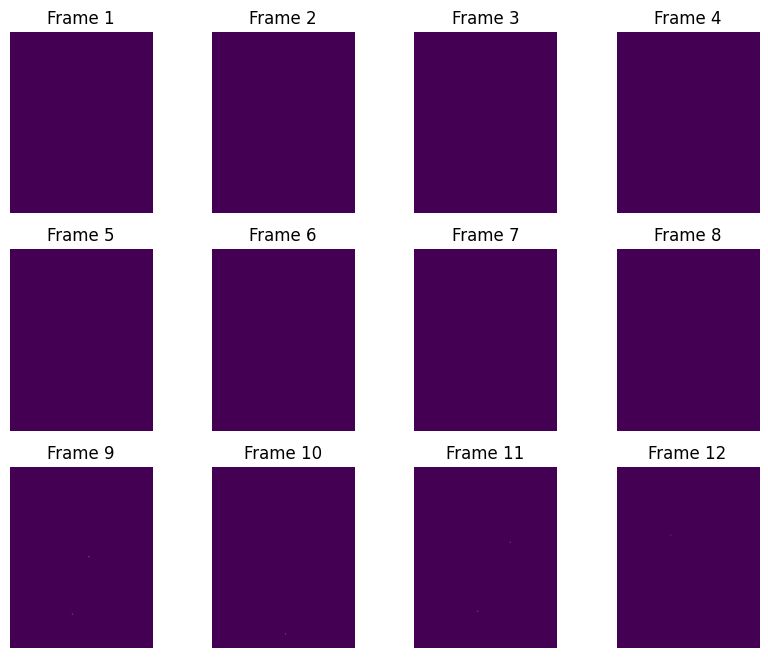

In [25]:
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(3,4, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
# data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(y_train[idx][0]))
    ax.imshow(np.squeeze(y_train[idx][1]))
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
# print(f"Displaying frames for example {data_choice}.")
plt.show()

In [26]:
def build_ConvLSTM():
    convlstm = models.Sequential()
    convlstm.add(layers.Input(shape=X_train_norm.shape[-4:]))
    convlstm.add(layers.ConvLSTM2D(filters=128, kernel_size=(5,5), padding="same", data_format="channels_last", activation="relu", return_sequences=True))
    convlstm.add(layers.BatchNormalization())
    convlstm.add(layers.ConvLSTM2D(filters=64, kernel_size=(3,3), padding="same", data_format="channels_last", activation="relu", return_sequences=True))
    convlstm.add(layers.BatchNormalization())
    convlstm.add(layers.ConvLSTM2D(filters=32, kernel_size=(2,2), padding="same", data_format="channels_last", activation="relu", return_sequences=True))
    convlstm.add(layers.BatchNormalization())
    convlstm.add(layers.ConvLSTM2D(filters=16, kernel_size=(1,1), padding="same", data_format="channels_last", activation="relu", return_sequences=True))
#     convlstm.add(layers.TimeDistributed(layers.Conv2D(filters=1, kernel_size=(3, 3), padding="same")))
    convlstm.add(layers.Conv3D(filters=1, kernel_size=(3, 3, 3), padding="same", data_format="channels_last", activation="sigmoid"))
    # https://www.baeldung.com/cs/convolutional-layer-size
    # image width/height - sum(kernel width/height) + num_kernels
    # kernel_size=(1, width_limit-11+4, height_limit-11+4)
    # https://keras.io/api/layers/recurrent_layers/time_distributed/
    convlstm.compile(
        loss=losses.binary_crossentropy, optimizer=optimizers.Adam(), metrics=[tf.keras.metrics.Accuracy()]
    )
    return convlstm

In [27]:
model = build_ConvLSTM()
print(model.summary())
epochs = 10
batch_size = 1

2023-05-07 07:55:06.199525: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-07 07:55:06.372850: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1637] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78868 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:90:00.0, compute capability: 8.0


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 2, 1253, 983, 128  2573312   
                             )                                   
                                                                 
 batch_normalization (BatchN  (None, 2, 1253, 983, 128  512      
 ormalization)               )                                   
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 2, 1253, 983, 64)  442624    
                                                                 
 batch_normalization_1 (Batc  (None, 2, 1253, 983, 64)  256      
 hNormalization)                                                 
                                                                 
 conv_lstm2d_2 (ConvLSTM2D)  (None, 2, 1253, 983, 32)  49280     
                                                        

In [ ]:
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test,y_test), verbose=True)

Epoch 1/10


2023-05-07 07:55:52.812572: I tensorflow/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8700
2023-05-07 07:56:08.230840: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 7.05GiB (rounded to 7567558656)requested by op sequential/conv_lstm2d/while/body/_1/sequential/conv_lstm2d/while/Mul
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-05-07 07:56:08.230905: I tensorflow/core/common_runtime/bfc_allocator.cc:1033] BFCAllocator dump for GPU_0_bfc
2023-05-07 07:56:08.230914: I tensorflow/core/common_runtime/bfc_allocator.cc:1040] Bin (256): 	Total Chunks: 92, Chunks in use: 92. 23.0KiB allocated for chunks. 23.0KiB in use in bin. 4.3KiB client-requested in use in bin.
2023-05-07 07:56:08.230919: I tensorflow/core/common_runtime/bfc_allocator.cc:1040] Bin (

2023-05-07 07:56:09.512779: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 7.05GiB (rounded to 7567558656)requested by op sequential/conv_lstm2d/while/body/_1/sequential/conv_lstm2d/while/convolution_6
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-05-07 07:56:09.512818: I tensorflow/core/common_runtime/bfc_allocator.cc:1033] BFCAllocator dump for GPU_0_bfc
2023-05-07 07:56:09.512834: I tensorflow/core/common_runtime/bfc_allocator.cc:1040] Bin (256): 	Total Chunks: 92, Chunks in use: 92. 23.0KiB allocated for chunks. 23.0KiB in use in bin. 4.3KiB client-requested in use in bin.
2023-05-07 07:56:09.512845: I tensorflow/core/common_runtime/bfc_allocator.cc:1040] Bin (512): 	Total Chunks: 12, Chunks in use: 12. 6.0KiB allocated for chunks. 6.0KiB in use in bin. 

2023-05-07 07:56:18.232396: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 7.05GiB (rounded to 7567558656)requested by op sequential/conv_lstm2d/while/body/_1/sequential/conv_lstm2d/while/convolution
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-05-07 07:56:18.232442: I tensorflow/core/common_runtime/bfc_allocator.cc:1033] BFCAllocator dump for GPU_0_bfc
2023-05-07 07:56:18.232456: I tensorflow/core/common_runtime/bfc_allocator.cc:1040] Bin (256): 	Total Chunks: 92, Chunks in use: 92. 23.0KiB allocated for chunks. 23.0KiB in use in bin. 4.3KiB client-requested in use in bin.
2023-05-07 07:56:18.232466: I tensorflow/core/common_runtime/bfc_allocator.cc:1040] Bin (512): 	Total Chunks: 12, Chunks in use: 12. 6.0KiB allocated for chunks. 6.0KiB in use in bin. 6.

2023-05-07 07:56:19.514496: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 7.05GiB (rounded to 7567558656)requested by op sequential/conv_lstm2d/while/body/_1/sequential/conv_lstm2d/while/convolution_7
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-05-07 07:56:19.514541: I tensorflow/core/common_runtime/bfc_allocator.cc:1033] BFCAllocator dump for GPU_0_bfc
2023-05-07 07:56:19.514554: I tensorflow/core/common_runtime/bfc_allocator.cc:1040] Bin (256): 	Total Chunks: 92, Chunks in use: 92. 23.0KiB allocated for chunks. 23.0KiB in use in bin. 4.3KiB client-requested in use in bin.
2023-05-07 07:56:19.514564: I tensorflow/core/common_runtime/bfc_allocator.cc:1040] Bin (512): 	Total Chunks: 12, Chunks in use: 12. 6.0KiB allocated for chunks. 6.0KiB in use in bin. 

2023-05-07 07:56:28.233887: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 7.05GiB (rounded to 7567558656)requested by op sequential/conv_lstm2d/while/body/_1/sequential/conv_lstm2d/while/convolution_1
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-05-07 07:56:28.233928: I tensorflow/core/common_runtime/bfc_allocator.cc:1033] BFCAllocator dump for GPU_0_bfc
2023-05-07 07:56:28.233935: I tensorflow/core/common_runtime/bfc_allocator.cc:1040] Bin (256): 	Total Chunks: 92, Chunks in use: 92. 23.0KiB allocated for chunks. 23.0KiB in use in bin. 4.3KiB client-requested in use in bin.
2023-05-07 07:56:28.233941: I tensorflow/core/common_runtime/bfc_allocator.cc:1040] Bin (512): 	Total Chunks: 12, Chunks in use: 12. 6.0KiB allocated for chunks. 6.0KiB in use in bin. 

2023-05-07 07:56:29.516388: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 7.05GiB (rounded to 7567558656)requested by op Func/sequential/conv_lstm2d/while/body/_1/input/_2988-0-0-TransposeNCHWToNHWC-LayoutOptimizer
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-05-07 07:56:29.516431: I tensorflow/core/common_runtime/bfc_allocator.cc:1033] BFCAllocator dump for GPU_0_bfc
2023-05-07 07:56:29.516439: I tensorflow/core/common_runtime/bfc_allocator.cc:1040] Bin (256): 	Total Chunks: 92, Chunks in use: 92. 23.0KiB allocated for chunks. 23.0KiB in use in bin. 4.3KiB client-requested in use in bin.
2023-05-07 07:56:29.516445: I tensorflow/core/common_runtime/bfc_allocator.cc:1040] Bin (512): 	Total Chunks: 12, Chunks in use: 12. 6.0KiB allocated for chunks. 6.0KiB i

In [ ]:
y_hat = model.predict(X_test)
print(y_hat.shape)
print(y_test.shape)
y_hat_mod = np.argmax (y_hat, axis = 1)
y_test_mod=np.argmax(y_test, axis=1)
print(y_hat_mod.flatten().shape)
print(y_test_mod.flatten().shape)

conf_mat = confusion_matrix(y_test_mod.flatten(), y_hat_mod.flatten())
disp = ConfusionMatrixDisplay(conf_mat)
disp.plot()
plt.savefig('conf_mat.png')
plt.show()
# plt.matshow(conf_mat)
# plt.savefig('conf_mat.png')
# plt.show()

In [ ]:
# print model keys
print(history.history.keys())

In [ ]:
# accuracy graph
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('acc.png')
plt.show()

In [ ]:
# loss graph
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()